In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.functions import density_contour

def bin_data(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr

In [32]:
# Load Cullan's data
req_cols = ["PGC", "objid", "RA", "Dec", "zhelio", "zcmb", "zcmb_group"]
df_h22 = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")[req_cols]

# Load Tempel et al data
with fits.open("../../data/external/tempel_group_sdss8/dr8_ggc.fits") as hdul:
    df_gal = Table(hdul[1].data).to_pandas()
    df_gr = Table(hdul[2].data).to_pandas()
req_cols = ["dr8objid", "zcl"]
df_tempel = df_gal.merge(df_gr, on="idcl", how="left")

df = df_h22.merge(df_tempel, left_on="objid", right_on="dr8objid")

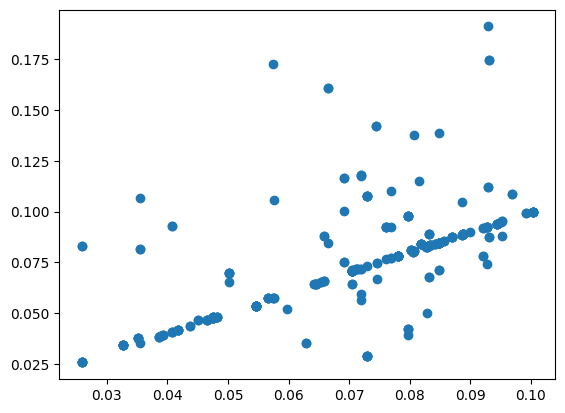

In [37]:
plt.scatter(df["zcmb_group"], df["zcl"])

In [28]:
df_tempel.columns

Index(['id', 'idcl', 'nrich_x', 'redshift', 'dist', 'distcl_x', 'ra', 'dec',
       'lon', 'lat', 'eta', 'lam', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z',
       'absmag_u', 'absmag_g', 'absmag_r', 'absmag_i', 'absmag_z', 'kcor_u',
       'kcor_g', 'kcor_r', 'kcor_i', 'kcor_z', 'lumr', 'w', 'rank', 'den1',
       'den2', 'den4', 'den8', 'den16', 'edgedist', 'morf', 'hcearly',
       'dr8objid', 'dr8specobjid', 'iddr7', 'zobs', 'distcor', 'flagfc',
       'nrich_y', 'zcl', 'distcl_y', 'racl', 'deccl', 'loncl', 'latcl',
       'etacl', 'lamcl', 'sizesky', 'rvir', 'sigma_sky', 'sigma_v', 'lumobs_r',
       'lumtot_r', 'dlink', 'den1cl', 'den2cl', 'den4cl', 'den8cl', 'den16cl',
       'edgedistcl', 'flagfccl'],
      dtype='object')

In [23]:
df_gr

,idcl,nrich,zcl,distcl,racl,deccl,loncl,latcl,etacl,lamcl,...,lumobs_r,lumtot_r,dlink,den1cl,den2cl,den4cl,den8cl,den16cl,edgedistcl,flagfccl
0,1,2,0.105321,308.841187,251.169052,28.180225,48.512871,38.862610,20.478033,53.737347,...,2.525737,4.577771,0.531,50.349079,9.456355,3.521289,5.291896,3.254674,10.794400,1
1,2,3,0.133109,387.964691,251.345276,28.481358,48.934929,38.781269,21.015720,53.621944,...,3.505311,8.971616,0.553,62.782082,16.573601,6.418639,4.262430,2.272363,11.298500,0
2,3,2,0.139386,405.697510,251.548233,28.555319,49.079639,38.624699,21.322081,53.687565,...,3.089046,8.679291,0.557,62.919991,16.228590,5.047269,3.461629,2.627947,10.491500,0
3,4,2,0.063151,186.862503,251.604828,28.467600,48.985100,38.556091,21.284678,53.785946,...,2.889047,3.666264,0.475,35.438370,8.008604,2.474880,1.496054,1.266728,5.366200,0
4,5,4,0.108520,318.002594,250.625763,27.464502,47.471821,39.160591,19.051125,53.921547,...,4.523615,8.490043,0.536,81.967651,17.999830,3.728609,2.210550,1.857290,15.294500,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77853,77854,2,0.023137,69.036697,251.672897,19.720432,38.466789,35.993488,9.652438,59.814659,...,0.325673,0.354370,0.359,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0
77854,77855,3,0.156612,454.098694,213.245819,22.515491,23.399500,70.955551,-7.300087,25.924215,...,6.824311,25.401489,0.565,293.218689,61.189560,19.101931,6.944697,2.510018,110.817703,0
77855,77856,2,0.100650,295.444000,228.345657,1.463561,1.950414,47.399212,-30.487864,43.328011,...,1.605964,2.766942,0.527,36.548061,7.007651,3.058627,2.055878,1.890962,21.611900,2
77856,77857,2,0.143272,416.650909,117.167229,21.734640,198.903503,21.910730,14.075151,-59.344666,...,2.413648,7.214652,0.559,71.299660,13.547940,2.096348,1.041106,0.783813,12.362100,0


Use Cullan's group redshift

In [7]:
# Load my data
df = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Load Cullan's data
req_cols = ["objid", "zhelio", "zcmb", "zcmb_group"]
df_h22 = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")[req_cols]
df_h22["objid"] = df_h22["objid"].apply(lambda x: "SDSS" + str(x))

In [8]:
df.head(3)

,tmass,objid,ra,dec,zhelio,z_cmb,z_dist_est,j_m_ext,extinction_j,kcor_j,...,logdist_rmse_lamost,logdist_mean_all_combined,logdist_std_all_combined,logdist_alpha_all_combined,logdist_loc_all_combined,logdist_scale_all_combined,logdist_all_combined,logdist_err_all_combined,logdist_chisq_all_combined,logdist_rmse_all_combined
0,2MASXJ09545075+5235243,SDSS1237657771783421957,148.711486,52.590090,0.034870,0.035474,0.03537,12.794,0.005556,-0.023675,...,0.013524,0.158351,0.090475,-0.646620,0.201842,0.100386,0.159442,0.090238,0.386242,0.007353
1,2MASXJ11134133+0745459,SDSS1237661972252131350,168.422213,7.762773,0.029096,0.030324,0.03030,12.874,0.024622,-0.020593,...,0.011445,-0.034016,0.094285,-0.727113,0.016082,0.106768,-0.032448,0.094230,0.655005,0.009951
2,2MASXJ08100249+2251416,SDSS1237661125073502284,122.510387,22.861575,0.040354,0.041119,0.04170,12.231,0.032931,-0.023576,...,0.007388,0.034432,0.094357,-0.694112,0.082639,0.105958,0.035811,0.094419,0.506575,0.008621


In [9]:
df_h22.head(3)

,objid,zhelio,zcmb,zcmb_group
0,SDSS1237654030328922362,0.086100,0.087418,0.08742
1,SDSS1237659329777107022,0.026256,0.026381,0.02638
2,SDSS1237671957519794394,0.088337,0.089384,0.08938


In [ ]:
# Replace with Cullan's redshifts
df = df[[col for col in df.columns if col not in ["zhelio", "z_cmb", "z_dist_est"]]]

df_ = df.merge(df_h22, on="objid")

df_.rename({"zcmb": "z_cmb", "zcmb_group": "z_dist_est"}, axis=1, inplace=True)
# df_.head(3)

df_.to_csv("./sdss_h22_z.csv", index=False)

,tmass,objid,ra,dec,j_m_ext,extinction_j,kcor_j,r,er,s,...,logdist_alpha_all_combined,logdist_loc_all_combined,logdist_scale_all_combined,logdist_all_combined,logdist_err_all_combined,logdist_chisq_all_combined,logdist_rmse_all_combined,zhelio,z_cmb,z_dist_est
0,2MASXJ09545075+5235243,SDSS1237657771783421957,148.711486,52.590090,12.794,0.005556,-0.023675,0.121975,0.035992,2.188996,...,-0.646620,0.201842,0.100386,0.159442,0.090238,0.386242,0.007353,0.034870,0.035474,0.03539
1,2MASXJ11134133+0745459,SDSS1237661972252131350,168.422213,7.762773,12.874,0.024622,-0.020593,-0.005727,0.036703,2.299941,...,-0.727113,0.016082,0.106768,-0.032448,0.094230,0.655005,0.009951,0.029096,0.030325,0.03034
2,2MASXJ08100249+2251416,SDSS1237661125073502284,122.510387,22.861575,12.231,0.032931,-0.023576,0.342176,0.029097,2.430566,...,-0.694112,0.082639,0.105958,0.035811,0.094419,0.506575,0.008621,0.040354,0.041119,0.04145


# Compare logdist with my redshift vs Cullan's redshift

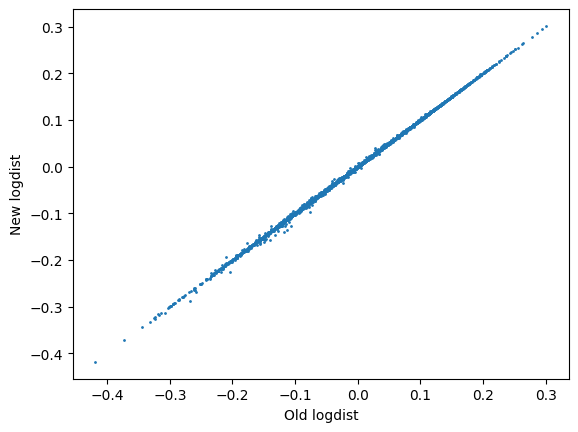

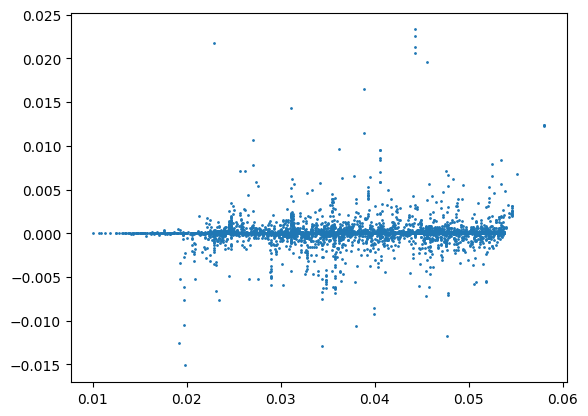

In [22]:
req_cols = ["objid", "logdist_all_combined", "logdist_err_all_combined"]
col_mapping = {
    "logdist_all_combined": "logdist",
    "logdist_err_all_combined": "logdist_err"
}

# Load old data
df_old = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")[req_cols]
df_old.rename(col_mapping, axis=1, inplace=True)

# Load new data
df_new = pd.read_csv("./sdss_logdist.csv")[req_cols + ["z_dist_est"]]
df_new.rename(col_mapping, axis=1, inplace=True)

# Join the two data
df = df_old.merge(df_new, on="objid", suffixes=("_old", "_new"))
df["delta_logdist"] = df["logdist_old"] - df["logdist_new"]

plt.figure()
plt.scatter(df["logdist_old"], df["logdist_new"], s=1)
plt.xlabel("Old logdist")
plt.ylabel("New logdist")

plt.figure()
plt.scatter(df["z_dist_est"], df["delta_logdist"], s=1)

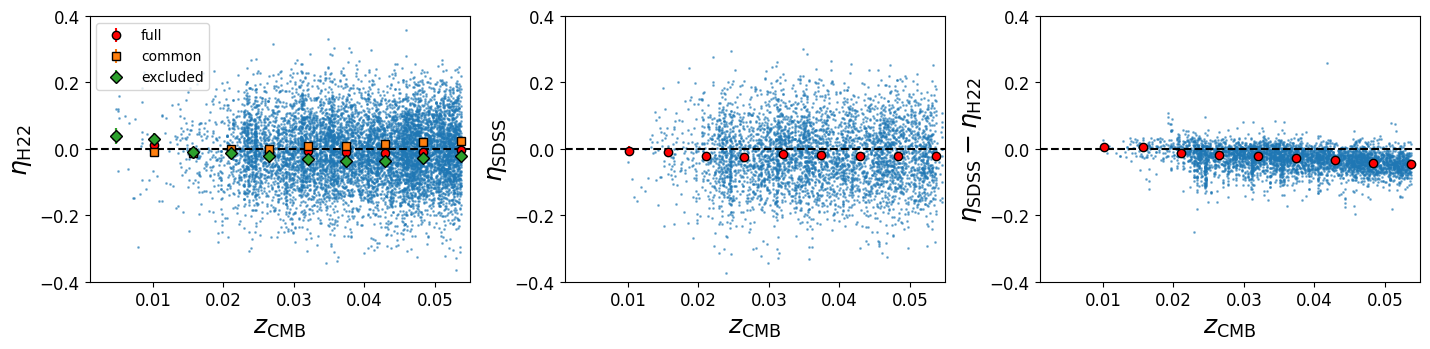

In [25]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("./sdss_logdist.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_cullan['objid'] = df_cullan['objid'].apply(lambda x: "SDSS" + str(x))
df_cullan = df_cullan[df_cullan['zcmb_group'] <= ZMAX]

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_corr', 'logdist_corr_err']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()
# fig.savefig('./sdss_comparison.pdf', bbox_inches='tight', dpi=300)